In [1]:
#! /usr/bin/env sage

import collections
R.<r,p> = QQ[]
#r,p = var("r, p")
#R = r.base_ring()

def my_vandermonde(v, ncols=None, ring=None):
    def entries(i, j):
        return v[i]**j
    if ncols is None:
        ncols = len(v)
    return matrix(entries, nrows=len(v), ncols=ncols, ring=ring)

class MoranRule:
    @staticmethod
    def name():
        return "moran"

    @staticmethod
    def rule_from(S, u, G, states_reducer):
        PS = collections.defaultdict(Integer)
        visited_states = []
        for v in G[u]:
            Sp = list(S)
            Sp[v] = S[u]
            Sp = states_reducer[tuple(Sp)]
            PS[Sp] += (r if S[u] else 1)/G.degree(u)
            visited_states.append(Sp)
        return PS, visited_states
    
    @staticmethod
    def vars_and_vales(N):
        """NOT TRUE: Return enough values for the computation of the rational functions.
        In our case, if the matrix is of size N all functions are rational functions on r
        with degree at most N. We can agree that r^N in denominator is 1:
             a₀ + a₁r + a₂r^2 + ··· + a_n r^N
            ----------------------------------
             b₀ + b₁r + b₂r^2 + ··· +     r^N
        Then, we need 2n + 1 values or r
        """
        
        rs = flatten([
            [ Integer(i) for i in range(1,N//2+2) ],
            [ 1/(Integer(i)+2) for i in range(N//2) ],
        ])
        rs = rs[:N]

        return [{r: val} for val in rs ]
        
    @staticmethod
    def row_phi(N):
        """
             a₀ + a₁r + a₂r^2 + ··· + a_n r^N
            ----------------------------------
                       DETERMINANT

        """
        retval = [r**i for i in range(N+1)]
        
        return retval

    @staticmethod
    def row_unconditional_time(N):
        """
             a₀ + a₁r + a₂r^2 + ··· + a_n r^N
            ----------------------------------
                       DETERMINANT

        """
        retval = [r**i for i in range(N+1)]
        
        return retval
        
    @staticmethod
    def row_conditional_time(N):
        """
            AdjQ AdjQ D_w barb  <-- deg 2n
            ------------------
            DETERMINANT PhiNum
            
            Then, the numerator is 
        """
        retval = [r**i for i in range(2*N+1)]
        
        return retval

    @staticmethod
    def recover_unconditional_timenum(row):
        return MoranRule.recover_phinum(row)
    
    @staticmethod
    def recover_conditional_timenum(row):
        return MoranRule.recover_phinum(row)
    
    @staticmethod
    def recover_phinum(row):
        return sum( val * r**i for i,val in enumerate(row) )
    
class BernoulliRule:
    @staticmethod
    def name():
        return "bernoulli"

    @staticmethod
    def rule_from(S, u, G, states_reducer):
        PS = collections.defaultdict(Integer)
        if S[u]: # Mutant... proliferation occurs
            Sp = list(S)
            for v in G[u]:
                Sp[v] = 1
            Sp = states_reducer[tuple(Sp)]
            PS[Sp] += r * p
            PS[S] += r * (1-p)
            return PS, [Sp]
        else:
            visited_states = []
            for v in G[u]:
                Sp = list(S)
                Sp[v] = 0
                Sp = states_reducer[tuple(Sp)]
                PS[Sp] += 1/G.degree(u)
                visited_states.append(Sp)
            return PS, visited_states

    @staticmethod
    def vars_and_vales(N):
        rs = [ random_prime(1000) for i in range(N) ]
        ps = [ 1/random_prime(1000) for i in range(N) ]
        
        return [{r: val, p:val2} for val, val2 in zip(rs, ps)]
    
    @staticmethod
    def row_phi(N):
        return [(r*p)**i for i in range(N+1)]
    
    @staticmethod
    def recover_phinum(row):
        return sum(val*(r*p)**i for i,val in enumerate(row))
        
    @staticmethod
    def row_unconditional_time(N):
        """
             a₀ + a₁(rp) + a₂(rp)^2 + ··· + a_n (rp)^N-1 + c₁r + c₂r(rp) + ··· + c_n r(rp)^N-1
            ----------------------------------------------------------------------------------
                               DETERMINANT
        """
        retval = [(r*p)**i for i in range(N)]
        retval.extend([r*v for v in retval])
        
        return retval
        
    @staticmethod
    def row_conditional_time(N):
        retval = [(r*p)**i for i in range(2*N)]
        retval.extend([r*v for v in retval])

        return retval

    @staticmethod
    def recover_unconditional_timenum(row):
        N = len(row)//2
        
        F = sum(val * (r*p)**i for i,val in enumerate(row[:N]))
        F += sum(val * r * (r*p)**i for i,val in enumerate(row[N:]))
        
        return F
    
    @staticmethod
    def recover_conditional_timenum(row):
        return BernoulliRule.recover_unconditional_timenum(row)

def posibleStates(G):
    bini = lambda x : tuple( [(x >> i) & 1 for i in range(G.order())] )
    
    P = G.automorphism_group()
    
    states_reducer = {bini(u):None for u in range((1<<G.order())+1)}
    
    for u, val in states_reducer.items():
        if val is None: # Not found early
            for p in P:
                newu = tuple( u[p(i)] for i in range(G.order()) )
                states_reducer[newu] = u
 
    return states_reducer

def sparse_system_matrix(G, states_reducer, rule):
    P = {}

    remaining_states = [ states_reducer[ 
                                (0,) * i +
                                (1,) + 
                                (0,) * (G.order()-i-1)
                               ] for i in range(G.order())]
    wSs = {}
    while remaining_states:
        S = remaining_states.pop()
        if S not in P:
            wS = sum(S)
            wS = G.order() - wS + r*wS
            wSs[S] = wS

            P[S] = collections.defaultdict(Integer)
            for u in G:
                PS, visited_states = rule.rule_from(S, u, G, states_reducer)
                for Sp, val in PS.items():
                    P[S][Sp] += val
                remaining_states.extend(visited_states)
            P[S] = dict(P[S])
                
    return P, wSs

def system_matrix(G, P, W):
    # Construct Matrix
    states = {w:i for i,w in enumerate(sorted(W))}
    Q = zero_matrix(R, len(W))
    for S,row in P.items():
        for Sp,val in row.items():
            Q[states[S],states[Sp]] = -val
        Q[states[S], states[S]] += W[S]

    b = vector(-Q[1:-1,-1])
    Q = Q[1:-1,1:-1]
    
    return Q, b, states

def worker(G, rule, outfile):
    states_reducer = posibleStates(G)
    P, W = sparse_system_matrix(G, states_reducer, rule)
    Q,b,used_states = system_matrix(G, P, W)
    w = vector(R, [0]*len(b))
    for s, weight in W.items(): # Probably you could trust python and the order of W but... 
        if len(used_states)-1 > used_states[s] > 0:
            w[used_states[s]-1] = weight
            #For example vector([ W[S] for S,val in states.items() if 0 < val < len(states)-1])

    print(f"{rule.name()}_P = {P}", file=outfile)
    print(f"{rule.name()}_W = {W}", file=outfile)
    print(f"{rule.name()}_Q = {list(Q)}", file=outfile)
    print(f"{rule.name()}_b = {b}", file=outfile)
    print(f"{rule.name()}_used_states = {used_states}", file=outfile)
    print(f"{rule.name()}_w = {w}", file=outfile)

    #
    # Firstly the phi
    #
    DETERMINANT = Q.determinant()#.factor()
    print(f"{rule.name()}_det = {DETERMINANT}", file=outfile)
    
    LHS = rule.row_phi(Q.ncols())
    values = rule.vars_and_vales(len(LHS))
    phis = [ Q.subs(s).change_ring(QQ).solve_right(b.subs(s).change_ring(QQ)) for s in values ]
    print(f"{rule.name()}_Phi_used_values = {values}", file=outfile)
    print(f"{rule.name()}_Phi_computed = {phis}", file=outfile)

    # Now I have to make the functions for each state with one single mutant
    PhiNum = {}
    for S,idx in used_states.items():
        if sum(S) == 1:
            V = matrix(QQ, [[v.subs(s) for v in LHS] for s in values])
            v = vector(QQ, [DETERMINANT.subs(s) * fs[idx-1] for s,fs in zip(values, phis)])

            assert V.rank() == V.ncols(), "I'm puzzled"
            
            PhiNum[S] = rule.recover_phinum(V.solve_right(v))
    print(f"{rule.name()}_PhiNum = {PhiNum}", file=outfile)

    # Mean value
    meanPhiNum = sum(PhiNum[S] for S in [ states_reducer[ 
                                    (0,) * i +
                                    (1,) + 
                                    (0,) * (G.order()-i-1)
                                   ] for i in range(G.order())]) / G.order()
    print(f"{rule.name()}_mean_phi = {(meanPhiNum/DETERMINANT)}", file=outfile)

    #
    # Unconditional Time
    #
    LHS = rule.row_unconditional_time(Q.ncols())
    values = rule.vars_and_vales(len(LHS))
    ucTimes = [ Q.subs(s).change_ring(QQ).solve_right(w.subs(s).change_ring(QQ)) for s in values ]
    print(f"{rule.name()}_UT_used_values = {values}", file=outfile)
    print(f"{rule.name()}_UT_computed = {ucTimes}", file=outfile)

    # Now I have to make the functions for each state with one single mutant
    Ts = {}
    for S,idx in used_states.items():
        if sum(S) == 1:
            V = matrix(QQ, [[v.subs(s) for v in LHS] for s,ts in zip(values, ucTimes)])
            v = vector(QQ, [DETERMINANT.subs(s) * ts[idx-1] for s,ts in zip(values, ucTimes)])

            assert V.rank() == V.ncols(), "I'm puzzled"
            
            Ts[S] = rule.recover_unconditional_timenum(V.solve_right(v))
    
    print(f"{rule.name()}_unconditional_times_num = {Ts}", file=outfile)

    # Mean value
    T = sum(Ts[S] for S in [ states_reducer[ 
                                    (0,) * i +
                                    (1,) + 
                                    (0,) * (G.order()-i-1)
                                   ] for i in range(G.order())]) / G.order()
    T /= DETERMINANT
    print(f"{rule.name()}_unconditional_mean_time_from1 = {T}", file=outfile)

    #
    # Conditional Time
    #
    LHS = rule.row_conditional_time(Q.ncols())
    values = rule.vars_and_vales(len(LHS))
    cTimes = []
    for s in values:
        _Q = Q.subs(s).change_ring(QQ)
        _b = b.subs(s).change_ring(QQ)
        _phi = _Q.solve_right(_b)

        _w = w.subs(s).change_ring(QQ)
        _w = vector(QQ, [x*y for x,y in zip(_phi,_w)])
        for i in range(_Q.ncols()):
            _Q.rescale_col(i, _phi[i])

        cTimes.append(_Q.solve_right(_w))
    print(f"{rule.name()}_CT_used_values = {values}", file=outfile)
    print(f"{rule.name()}_CT_computed = {cTimes}", file=outfile)

    # Now I have to make the functions for each state with one single mutant
    Ts = {}
    for S,idx in used_states.items():
        if sum(S) == 1:
            V = matrix(QQ, [[v.subs(s) for v in LHS] for s,ts in zip(values, cTimes)])            
            v = vector(QQ, [ DETERMINANT.subs(s) * PhiNum[S].subs(s) * ts[idx-1] for s,ts in zip(values, cTimes)])
            assert V.rank() == V.ncols(), "I'm puzzled"
            Ts[S] = (rule.recover_conditional_timenum(V.solve_right(v)) / PhiNum[S] / DETERMINANT)#.factor()

    print(f"{rule.name()}_conditional_times = {Ts}", file=outfile)

    # Mean value
    T = sum(Ts[S] for S in [ states_reducer[ 
                                    (0,) * i +
                                    (1,) + 
                                    (0,) * (G.order()-i-1)
                                   ] for i in range(G.order())]) / G.order()
    #T = T.factor()
    print(f"{rule.name()}_conditional_mean_time_from1 = {T}", file=outfile)


def compute_all(name, G):
    with open(f"{name}.txt", "wt") as outfile:
        print(f"G = {G.edges(labels=false,sort=True)}", file=outfile)

        for rule in [MoranRule, BernoulliRule]:
            worker(G, rule, outfile)
        

In [2]:
if os.path.isfile(f"{sys.argv[-1]}.txt"):
    quit()

for i,G in enumerate(G for G in graphs(6) if G.is_connected()):
    if i == int(sys.argv[-1]):
        break

compute_all(i, G)


ValueError: invalid literal for int() with base 10: '/home/alvaro/.local/share/jupyter/runtime/kernel-b527dd0e-6b90-4689-9e91-e2086370ae15.json'

In [2]:
for i,G in enumerate(G for G in graphs(6) if G.is_connected()):
    if i == 9:
        break


In [7]:
rule = BernoulliRule
outfile = None

states_reducer = posibleStates(G)
P, W = sparse_system_matrix(G, states_reducer, rule)
Q,b,used_states = system_matrix(G, P, W)
w = vector(R, [0]*len(b))
for s, weight in W.items(): # Probably you could trust python and the order of W but... 
    if len(used_states)-1 > used_states[s] > 0:
        w[used_states[s]-1] = weight
        #For example vector([ W[S] for S,val in states.items() if 0 < val < len(states)-1])

#
# Firstly the phi
#
DETERMINANT = Q.determinant()#.factor()

LHS = rule.row_phi(Q.ncols())
values = rule.vars_and_vales(len(LHS))
phis = [ Q.subs(s).change_ring(QQ).solve_right(b.subs(s).change_ring(QQ)) for s in values ]

# Now I have to make the functions for each state with one single mutant
PhiNum = {}
for S,idx in used_states.items():
    if sum(S) == 1:
        V = matrix(QQ, [[v.subs(s) for v in LHS] for s in values])
        v = vector(QQ, [DETERMINANT.subs(s) * fs[idx-1] for s,fs in zip(values, phis)])

        assert V.rank() == V.ncols(), "I'm puzzled"

        PhiNum[S] = rule.recover_phinum(V.solve_right(v))

# Mean value
meanPhiNum = sum(PhiNum[S] for S in [ states_reducer[ 
                                (0,) * i +
                                (1,) + 
                                (0,) * (G.order()-i-1)
                               ] for i in range(G.order())]) / G.order()


#
# Conditional Time
#
LHS = rule.row_conditional_time(Q.ncols())
values = rule.vars_and_vales(len(LHS))
cTimes = []
for s in values:
    _Q = Q.subs(s).change_ring(QQ)
    _b = b.subs(s).change_ring(QQ)
    _phi = _Q.solve_right(_b)

    _w = w.subs(s).change_ring(QQ)
    _w = vector(QQ, [x*y for x,y in zip(_phi,_w)])
    for i in range(_Q.ncols()):
        _Q.rescale_col(i, _phi[i])

    cTimes.append(_Q.solve_right(_w))
print(f"{rule.name()}_CT_used_values = {values}", file=outfile)
print(f"{rule.name()}_CT_computed = {cTimes}", file=outfile)

# Now I have to make the functions for each state with one single mutant
Ts = {}
for S,idx in used_states.items():
    if sum(S) == 1:
        V = matrix(QQ, [[v.subs(s) for v in LHS] for s,ts in zip(values, cTimes)])            
        v = vector(QQ, [ DETERMINANT.subs(s) * PhiNum[S].subs(s) * ts[idx-1] for s,ts in zip(values, cTimes)])
        assert V.rank() == V.ncols(), "I'm puzzled"
        Ts[S] = (rule.recover_conditional_timenum(V.solve_right(v)) / PhiNum[S] / DETERMINANT)#.factor()

print(f"{rule.name()}_conditional_times = {Ts}", file=outfile)

# Mean value
T = sum(Ts[S] for S in [ states_reducer[ 
                                (0,) * i +
                                (1,) + 
                                (0,) * (G.order()-i-1)
                               ] for i in range(G.order())]) / G.order()
#T = T.factor()
print(f"{rule.name()}_conditional_mean_time_from1 = {T}", file=outfile)


bernoulli_CT_used_values = [{r: 419, p: 1/97}, {r: 307, p: 1/5}, {r: 977, p: 1/439}, {r: 859, p: 1/541}, {r: 739, p: 1/109}, {r: 29, p: 1/43}, {r: 709, p: 1/941}, {r: 883, p: 1/719}, {r: 61, p: 1/467}, {r: 197, p: 1/269}, {r: 487, p: 1/863}, {r: 103, p: 1/239}, {r: 373, p: 1/701}, {r: 43, p: 1/653}, {r: 271, p: 1/257}, {r: 139, p: 1/509}, {r: 769, p: 1/811}, {r: 701, p: 1/947}, {r: 383, p: 1/863}, {r: 757, p: 1/947}, {r: 547, p: 1/733}, {r: 349, p: 1/859}, {r: 751, p: 1/997}, {r: 701, p: 1/659}, {r: 53, p: 1/647}, {r: 241, p: 1/719}, {r: 619, p: 1/691}, {r: 823, p: 1/757}, {r: 941, p: 1/571}, {r: 307, p: 1/317}, {r: 439, p: 1/127}, {r: 487, p: 1/401}, {r: 103, p: 1/373}, {r: 211, p: 1/463}, {r: 613, p: 1/383}, {r: 227, p: 1/449}, {r: 347, p: 1/263}, {r: 317, p: 1/79}, {r: 307, p: 1/37}, {r: 101, p: 1/877}, {r: 271, p: 1/17}, {r: 829, p: 1/877}, {r: 499, p: 1/761}, {r: 97, p: 1/643}, {r: 223, p: 1/23}, {r: 13, p: 1/769}, {r: 383, p: 1/937}, {r: 907, p: 1/853}, {r: 383, p: 1/479}, {r: 47

bernoulli_conditional_times = {(0, 0, 0, 0, 0, 1): (13695130288521216*r^50*p^49 + 27390260577042432*r^49*p^49 + 365726552253530112*r^49*p^48 + 687799876712398848*r^48*p^48 + 4755926614152314880*r^48*p^47 + 8412792274349457408*r^47*p^47 + 40179557898523901952*r^47*p^46 + 66888183539963658240*r^46*p^46 + 248249266918684360704*r^46*p^45 + 389245927964507209728*r^45*p^45 + 1197241113433688745984*r^45*p^44 + 1769994304418366171136*r^44*p^44 + 4697637728046677981184*r^44*p^43 + 6556819734464211363840*r^43*p^43 + 15433719315119983556352*r^43*p^42 + 20369603797027284718080*r^42*p^42 + 130097614733176495168256/3*r^42*p^41 + 162652062572839583855488/3*r^41*p^41 + 953257625029887928753136/9*r^41*p^40 + 1131266771061418548008560/9*r^40*p^40 + 2050010071349769990669056/9*r^40*p^39 + 2314565509408103299178716/9*r^39*p^39 + 70602667783514942139601829/162*r^39*p^38 + 76032066449838678833208967/162*r^38*p^38 + 363668117890868076845756515/486*r^38*p^37 + 749177559872539316347146163/972*r^37*p^37 + 94057

In [124]:
G = graphs.CompleteGraph(3)
rule = BernoulliRule

states_reducer = posibleStates(G)
P, W = sparse_system_matrix(G, states_reducer, rule)
Q,b,used_states = system_matrix(G, P, W)
w = vector(R, [0]*len(b))

for s, weight in W.items(): # Probably you could trust python and the order of W but... 
    if len(used_states)-1 > used_states[s] > 0:
        w[used_states[s]-1] = weight

for s in [{r: 1, p: 1}, {r: 2, p: 1}, {r: 3, p: 1}, {r: 4, p: 1}, {r: 1/2, p: 1}, {r: 1/3, p: 1}]:
    print(Q.solve_right(w)[0].subs(s))
rule.row_conditional_time(Q.ncols())

3/2
4/3
5/4
6/5
5/3
7/4


[1, r*p, r, r^2*p]

In [125]:
worker(G, BernoulliRule, None)

bernoulli_P = {(1, 0, 0): {(1, 1, 1): r*p, (1, 0, 0): -r*p + r + 1, (0, 0, 0): 1}, (0, 0, 0): {(0, 0, 0): 3}, (1, 1, 1): {(1, 1, 1): 3*r}}
bernoulli_W = {(1, 0, 0): r + 2, (0, 0, 0): 3, (1, 1, 1): 3*r}
bernoulli_Q = [(r*p + 1)]
bernoulli_b = (r*p)
bernoulli_used_states = {(0, 0, 0): 0, (1, 0, 0): 1, (1, 1, 1): 2}
bernoulli_w = (r + 2)
bernoulli_det = r*p + 1
bernoulli_Phi_used_values = [{r: 2, p: 1/4}, {r: 3, p: 1/2}]
bernoulli_Phi_computed = [(1/3), (3/5)]
bernoulli_PhiNum = {(1, 0, 0): r*p}
bernoulli_mean_phi = r*p/(r*p + 1)
bernoulli_UT_used_values = [{r: 2, p: 1/4}, {r: 3, p: 1/2}]
bernoulli_UT_computed = [(8/3), (2)]
bernoulli_unconditional_times_num = {(1, 0, 0): r + 2}
bernoulli_unconditional_mean_time_from1 = (r + 2)/(r*p + 1)
bernoulli_CT_used_values = [{r: 2, p: 1/6}, {r: 3, p: 1/3}, {r: 4, p: 1/2}, {r: 1/2, p: 2/3}]
bernoulli_CT_computed = [(3), (5/2), (2), (15/8)]
bernoulli_conditional_times = {(1, 0, 0): (r + 2)/(r*p + 1)}
bernoulli_conditional_mean_time_from1 = (3*r + 6)/

In [64]:
[(r/(p*r + 1)).subs(s) for s in [{r: 2, p: 1/2}, {r: 2, p: 1/3}, {r: 3, p: 1/2}, {r: 3, p: 1/3}]]

[1, 6/5, 6/5, 3/2]

In [10]:
expr = 3/20*(3*p*r^2 + 16*p*r + 29*r - 12)/((p*r + 1)*r)
[expr.subs(s) for s in [{r: 2, p: 1/6}, {r: 3, p: 1/3}, {r: 4, p: 1/2}, {r: 1/2, p: 2/3}]]

[3, 5/2, 2, 15/8]

In [27]:
phi=(p*r / ((p - 1)*r + r + 1)).factor()

In [179]:
F = (p*r^2 + p*r - 2)/((p*r + 1)*(p*r - 1))
F2 = (r + 2)/(p*r + 1)
for s in [{r: 2, p: 1}, {r: 3, p: 1}, {r: 4, p: 1}, {r: 5, p: 1}, {r: 1/2, p: 1}, {r: 1/3, p: 1}]:
    print(F.subs(s), F2.subs(s))

4/3 4/3
5/4 5/4
6/5 6/5
7/6 7/6
5/3 5/3
7/4 7/4


In [207]:
F.subs(p=1).factor()

(r + 2)/(r + 1)

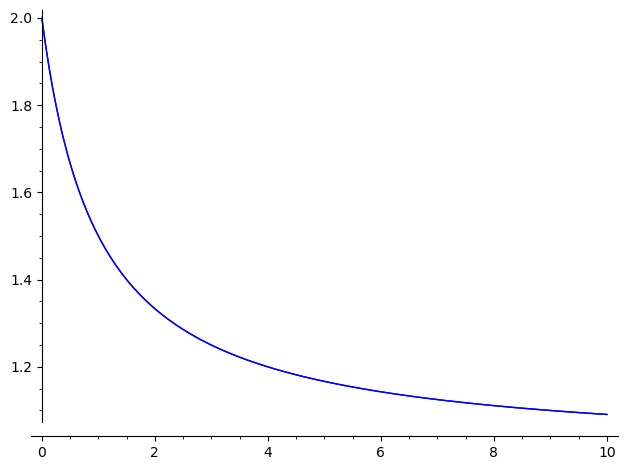

In [206]:
plot(F2.subs(p=1),(r,0,10)) + plot(F.subs(p=1),(r,0,10))

In [198]:
for i in range(2,100):
    print(F.subs(p=1,r=i), F2.subs(p=1,r=i))

4/3 4/3
5/4 5/4
6/5 6/5
7/6 7/6
8/7 8/7
9/8 9/8
10/9 10/9
11/10 11/10
12/11 12/11
13/12 13/12
14/13 14/13
15/14 15/14
16/15 16/15
17/16 17/16
18/17 18/17
19/18 19/18
20/19 20/19
21/20 21/20
22/21 22/21
23/22 23/22
24/23 24/23
25/24 25/24
26/25 26/25
27/26 27/26
28/27 28/27
29/28 29/28
30/29 30/29
31/30 31/30
32/31 32/31
33/32 33/32
34/33 34/33
35/34 35/34
36/35 36/35
37/36 37/36
38/37 38/37
39/38 39/38
40/39 40/39
41/40 41/40
42/41 42/41
43/42 43/42
44/43 44/43
45/44 45/44
46/45 46/45
47/46 47/46
48/47 48/47
49/48 49/48
50/49 50/49
51/50 51/50
52/51 52/51
53/52 53/52
54/53 54/53
55/54 55/54
56/55 56/55
57/56 57/56
58/57 58/57
59/58 59/58
60/59 60/59
61/60 61/60
62/61 62/61
63/62 63/62
64/63 64/63
65/64 65/64
66/65 66/65
67/66 67/66
68/67 68/67
69/68 69/68
70/69 70/69
71/70 71/70
72/71 72/71
73/72 73/72
74/73 74/73
75/74 75/74
76/75 76/75
77/76 77/76
78/77 78/77
79/78 79/78
80/79 80/79
81/80 81/80
82/81 82/81
83/82 83/82
84/83 84/83
85/84 85/84
86/85 86/85
87/86 87/86
88/87 88/87
89/88 

In [6]:
def compute(G, rule):
    states_reducer = posibleStates(G)
    P, W = sparse_system_matrix(G, states_reducer, rule)
    Q,b,used_states = system_matrix(G, P, W)
    
    
    
    
    return Q
    # Now... we need to construct the Phis
    

In [51]:
compute(graphs.CompleteGraph(3), BernoulliRule)

[(p - 1)*r + r + 1]

In [6]:
def times(G,P,Q,W, states, Phi):
    Q = Q.change_ring(Phi.base_ring())
    wvector = vector([ W[S] for S,val in states.items() if 0 < val < len(states)-1])
    unconditional_times = Q.solve_right(wvector)
    
    wvector = vector([ W[S]*Phi[val-1] for S,val in states.items() if 0 < val < len(states)-1])
    for i in range(Q.ncols()):
        Q.rescale_col(i, Phi[i])
    
    conditional_fixation_time = Q.solve_right(wvector)
    
    return unconditional_times, conditional_fixation_time

In [7]:
def compute_for_rule(G, rule):
    states_reducer = posibleStates(G)
    P, W = system_matrix(G, states_reducer, rule)

    Phi, Q, b, states = fixProbability(G, P, W)
    unconditional_times, conditional_fixation_time = times(G, P, Q, W, states, Phi)
    
    return Phi, unconditional_times, conditional_fixation_time, states

In [76]:
def compute_all(name,G):
    with open(f"{name}.txt", "wt") as outfile:
        print(f"G = {G.edges(labels=false)}", file=outfile)
        
        for name in ["Moran", "Bernoulli"]:
            Phi, unconditional_times, conditional_fixation_times, states = compute_for_rule(G, globals()[f"{name}Rule"])
            print(f"Phi{name} = {Phi}", file=outfile)
            print(f"unconditional_times_{name} = {unconditional_times}", file=outfile)
            print(f"conditional_fixation_time_{name} = {conditional_fixation_times}", file=outfile)
            print(f"states_{name} = {states}", file=outfile)
    

In [77]:
G=graphs.CompleteBipartiteGraph(1,5)

In [78]:
states, reducedStates = posibleStates(G)
P, W = system_matrix(G, states, MoranRule)

In [144]:
states = {w:i for i,w in enumerate(sorted(W, key=sum))}
Q = zero_matrix(R, len(W))
for S,row in P.items():
    for Sp,val in row.items():
        Q[states[S],states[Sp]] = -val
    Q[states[S], states[S]] += W[S]

b = vector(-Q[1:-1,-1])
Q = Q[1:-1,1:-1]


In [185]:
n = Q.ncols() + 1
rs = flatten([
    [ Integer(i)/n for i in range(n) ],
    [ Integer(i) for i in range(1,n) ],
])
assert len(rs) == 2*n - 1
assert len(set(rs)) == len(rs)
print(n, len(rs))

10 19


In [146]:
Phis = [matrix(QQ, Q.subs({r:val})).solve_right(b.subs({r:val})) for val in rs]

In [179]:
V1 = my_vandermonde(rs[:n])
V2 = my_vandermonde(rs[n:], n)

In [190]:
V2.nrows()

9

In [196]:
state_num = 0
phi_vec = [x[state_num] for x in Phis]
A = block_matrix(QQ,[[V1, -diagonal_matrix(phi_vec[:n]) * V1[:,:-1]], [V2, -diagonal_matrix(phi_vec[n:])*V2[:,:-1]]])

Rational Field

In [37]:
n(prod((lcm(G.degree()) * Q).column(i) * (lcm(G.degree()) * Q).column(i) for i in range(Q.nrows())).subs({r:1}))

1.81336663331377e24

In [ ]:
Q.inverse()

In [70]:
show(Q.echelon_form())

[                     1                      0             -1/5*r - 1                      0                  1/5*r                      0                      0                      0                      0]
[                     0                      0                      0                      1             -1/5*r - 1                      0                  1/5*r                      0                      0]
[                     0                      0                      0                      0                      0                      1             -1/5*r - 1                      0                  1/5*r]
[                     0                      0                      0                      0                      0                      0                      0                      1             -1/5*r - 1]
[                     0                  r + 5                     -r                      0                      0                      0                      0                      0                      0]
[                     0                      0                      0                      0          -3/25*r - 3/5                      0 3/5*r^2 + 6/25*r + 3/5                      0      -3/5*r^2 - 3/25*r]
[                     0                      0 1/5*r^2 + 1/25*r + 1/5                      0      -1/5*r^2 - 1/25*r                      0                      0                      0                      0]
[                     0                      0                      0                      0                      0                      0          -4/25*r - 4/5                      0 4/5*r^2 + 8/25*r + 4/5]
[                     0                      0          -2/25*r - 2/5                      0 2/5*r^2 + 4/25*r + 2/5                      0      -2/5*r^2 - 2/25*r                      0                      0]

In [16]:
compute_all("1", graphs.CycleGraph(6)) 

In [17]:
G=graphs.CompleteGraph(6)

In [13]:
for i,G in enumerate(G for G in graphs(6) if G.is_connected()):
    if i == 10:
        break

In [53]:
len(list(G for G in graphs(6) if G.is_connected()))

112